In [4]:
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Temperaturen u, m, o
# Wassermenge: uw, mw, ow
waermekapazitaet_J_kg_K = 4190

# minimale Temperatur zum Duschen.
# z.B. https://www.edeka.de/ernaehrung/beauty/ideale-duschtemperatur-im-sommer.jsp
# Die ideale Duschtemperatur bewegt sich im Bereich der Koerpertemperatur, also um die 37 °C. 
# Wer es etwas waermer mag, kann die Wassertemperatur auf bis zu 43 °C erhoehen, wer lieber kaelter duscht, 
# kann die Wassertemperatur auf bis zu 18 °C senken.""
dusch_temperatur_min_C = 40.0

# Fuer Heizung minimale Speichertemperatur
# heizkurve_heizungswasser_C = (20.0 - self.stimuli.umgebungstemperatur_C) * 10.0 / 28.0 + 25.0  # gemaess Heizkurve VC Engineering
heiz_temperatur_min_C = 35.0 # minimale Temperatur zum Heizen

dezentral_wasser_total_kg = 690
unten_wasser_kg = dezentral_wasser_total_kg * 40.0/100.0 # diese Faktoren sind gewaehlt in Anlehnung an das Volumen bei den Sensoren
mitte_wasser_kg = dezentral_wasser_total_kg * 30.0/100.0 # diese Faktoren sind gewaehlt in Anlehnung an das Volumen bei den Sensoren
oben_wasser_kg = dezentral_wasser_total_kg * 30.0/100.0 # diese Faktoren sind gewaehlt in Anlehnung an das Volumen bei den Sensoren
assert abs(unten_wasser_kg + mitte_wasser_kg + oben_wasser_kg - dezentral_wasser_total_kg) < 0.1

# Fuer die definition der Ladung 100%
unten_max_C = 45.0
mitte_max_C = 65.0
oben_max_C = 65.0

def energie_baden_J(unten_C, mitte_C, oben_C):
    global unten_wasser_kg, mitte_wasser_kg, oben_wasser_kg, dusch_temperatur_min_C, waermekapazitaet_J_kg_K
    if oben_C > dusch_temperatur_min_C:
        energie_u_J = (unten_C-dusch_temperatur_min_C)*unten_wasser_kg*waermekapazitaet_J_kg_K
        energie_m_J = (mitte_C-dusch_temperatur_min_C)*mitte_wasser_kg*waermekapazitaet_J_kg_K
        energie_o_J = (oben_C-dusch_temperatur_min_C)*oben_wasser_kg*waermekapazitaet_J_kg_K
        energie_J = max(energie_u_J, 0) + max(energie_m_J, 0) + max(energie_o_J, 0)
    else:
        energie_J = (oben_C-dusch_temperatur_min_C) * (unten_wasser_kg+mitte_wasser_kg+oben_wasser_kg) * waermekapazitaet_J_kg_K
    return energie_J

maximale_energie_duschen_J = energie_baden_J(unten_max_C, mitte_max_C, oben_max_C)

def fuellgrad_baden_prozent(unten_C, mitte_C, oben_C):
    global maximale_energie_duschen_J
    ladestand_0_prozent_J = energie_baden_J(0, 40, 50) # es beraucht diese Energie um eine Badewanne zu fuellen
    prozent = (energie_baden_J(unten_C, mitte_C, oben_C)-ladestand_0_prozent_J)/(maximale_energie_duschen_J-ladestand_0_prozent_J)*100.0
    return prozent

def energie_heizen_J(unten_C, mitte_C, oben_C):
    global unten_wasser_kg, mitte_wasser_kg, oben_wasser_kg, heiz_temperatur_min_C, waermekapazitaet_J_kg_K
    if mitte_C > heiz_temperatur_min_C:
        energie_u_J = (unten_C-heiz_temperatur_min_C)*unten_wasser_kg*waermekapazitaet_J_kg_K
        energie_m_J = (mitte_C-heiz_temperatur_min_C)*mitte_wasser_kg*waermekapazitaet_J_kg_K
        energie_J = max(energie_u_J, 0) + max(energie_m_J, 0)
    else:
        energie_J = (mitte_C-heiz_temperatur_min_C) * (unten_wasser_kg+mitte_wasser_kg) * waermekapazitaet_J_kg_K
    return energie_J

def fuellgrad_heizen_prozent(unten_C, mitte_C, oben_C):
    prozent = energie_heizen_J(unten_C, mitte_C, oben_C)/energie_heizen_J(unten_max_C, mitte_max_C, oben_C) * 100.0
    return prozent

def fuellgrad_dezentral_prozent(unten_C, mitte_C, oben_C):
    faktor_heizen = 1.0 # damit das Heizen wenig Einfluss hat, nur fall die Heizreserven unter null sind, z.B. 2 bis 5
    heizen =  fuellgrad_heizen_prozent(unten_C, mitte_C, oben_C)
    baden =  fuellgrad_baden_prozent(unten_C, mitte_C, oben_C)
    return min(heizen, baden)

In [6]:
print(fuellgrad_dezentral_prozent(45, 65, 65))

100.0


In [7]:
import numpy as np
import matplotlib.pyplot as plt

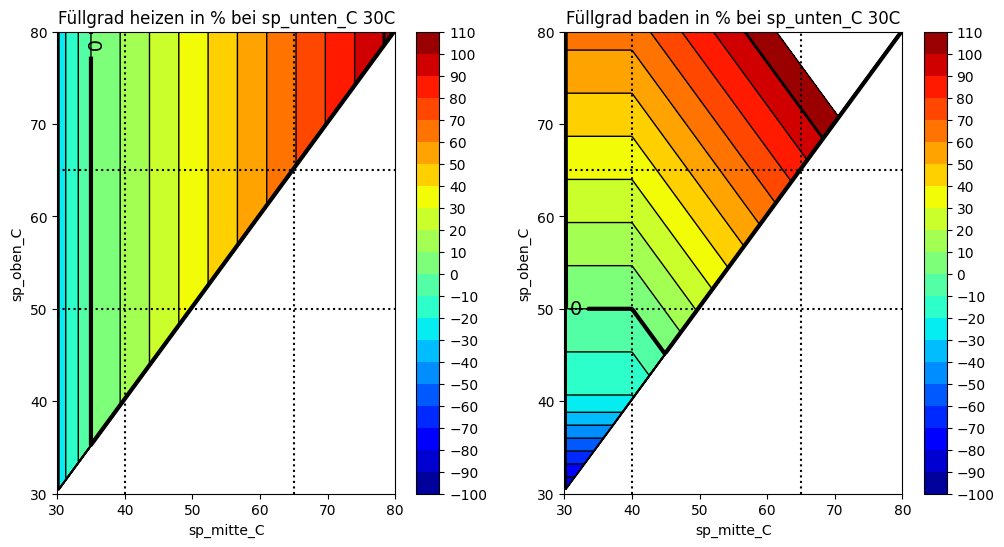

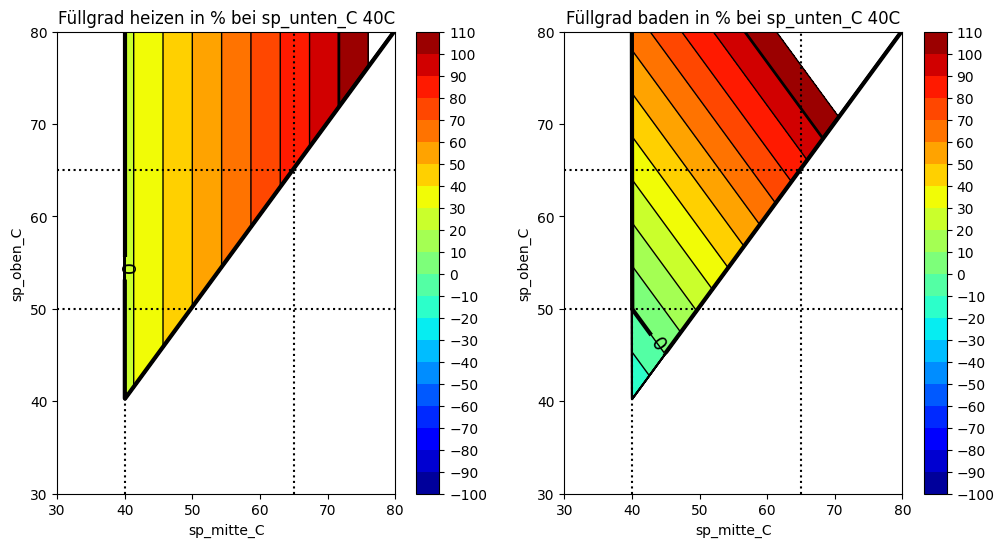

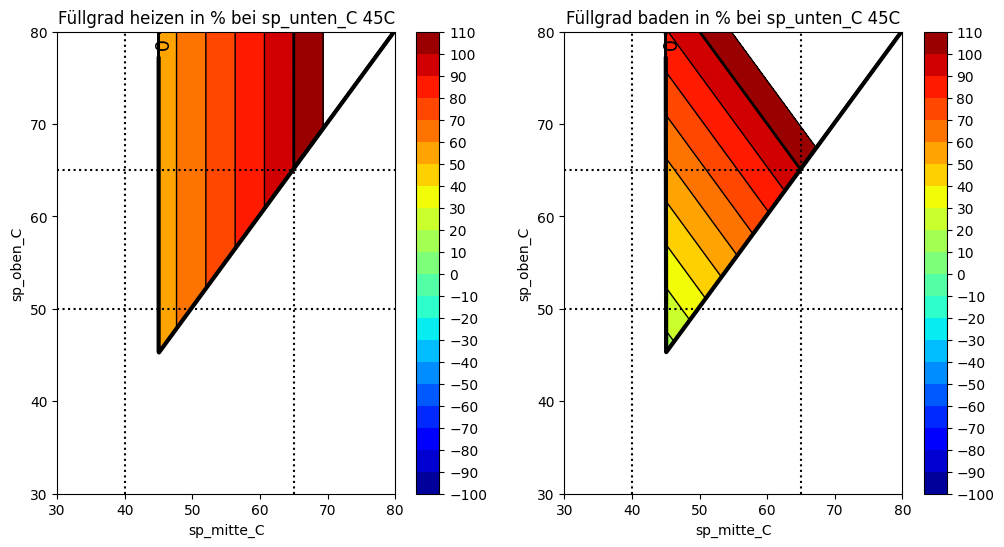

In [8]:
mitte_linspace = np.linspace(30, 80, 200) 
oben_linspace = np.linspace(30, 80, 200)

Z = np.zeros((len(mitte_linspace), len(oben_linspace)))

levels = np.linspace(-100, 110, 22) 

for dezentral_unten_C in [30, 40, 45]:
    #fig,ax=plt.subplots(1,1)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6)) # 1 Reihe, 2 Spalten

    durchlauf = ['heizen','baden']

    for ax, durchlauf in zip(axs,durchlauf):

        for i, mitte in enumerate(mitte_linspace):
            for j, oben in enumerate(oben_linspace):
                if mitte > dezentral_unten_C and oben > mitte:
                    if durchlauf == 'heizen':
                        Z[j, i] = fuellgrad_heizen_prozent(dezentral_unten_C, mitte, oben)
                    else:
                        Z[j, i] = fuellgrad_baden_prozent(dezentral_unten_C, mitte, oben)
                else:
                    Z[j, i] = -200.0 # nicht moeglich

        cp = ax.contourf(mitte_linspace, oben_linspace, Z, levels=levels,cmap='jet') # cmap: https://matplotlib.org/stable/users/explain/colors/colormaps.html
        cbar = fig.colorbar(cp, extend='min')
        cbar.set_ticks(levels)
        #fig.colorbar(cp) # Add a colorbar to a plot
        ax.set_xticks(range(20, 90, 10))
        ax.set_yticks(range(20, 90, 10))
        contour1 = ax.contour(mitte_linspace, oben_linspace, Z, levels=[0], colors='black', linestyles='solid', linewidths=3)
        contour2 = ax.contour(mitte_linspace, oben_linspace, Z, levels=[100], colors='black', linestyles='solid', linewidths=2)
        plt.clabel(contour1, inline=True, fontsize=14)
        #plt.clabel(contour2, inline=True, fontsize=8)
        for level in levels:
            contour = ax.contour(mitte_linspace, oben_linspace, Z, levels=[level], colors='black', linestyles='solid', linewidths=1)
            #plt.clabel(contour, inline=True, fontsize=10)
        ax.axhline(y=50, color='black', linestyle='dotted')
        ax.axhline(y=65, color='black', linestyle='dotted')
        ax.axvline(x=40, color='black', linestyle='dotted')
        ax.axvline(x=65, color='black', linestyle='dotted')
        if durchlauf == 'heizen':
            ax.set_title(f'Füllgrad heizen in % bei sp_unten_C {dezentral_unten_C}C', fontsize=12)
        else:
            ax.set_title(f'Füllgrad baden in % bei sp_unten_C {dezentral_unten_C}C', fontsize=12)
        
        ax.set_xlabel('sp_mitte_C')
        ax.set_ylabel('sp_oben_C')
    plt.show()

In [9]:
# http://maerki.com:3000/d/fh7gxF_Vk/puenterswis?orgId=1&refresh=5s&from=1708795216278&to=1711387216278&viewPanel=14
# Zelglitrasse 53

with open("20240325_raw_temperature_data.txt") as inp:
    data=  np.transpose(list(zip(*(line.strip().split('\t') for line in inp)))) 

In [10]:
t = range(data.shape[0])
ulist = np.zeros(data.shape[0])
mlist = np.zeros(data.shape[0])
olist = np.zeros(data.shape[0])
heizen_list = np.zeros(data.shape[0])
baden_list = np.zeros(data.shape[0])
for i, liste in zip(t, data):
    ulist[i]=float(liste[1])
    mlist[i]=float(liste[2])
    olist[i]=float(liste[3])
    unten_C=float(liste[1])
    mitte_C=float(liste[2])
    oben_C=float(liste[3])
    heizen_list[i] = fuellgrad_heizen_prozent(unten_C, mitte_C, oben_C)
    baden_list[i] = fuellgrad_baden_prozent(unten_C, mitte_C, oben_C)


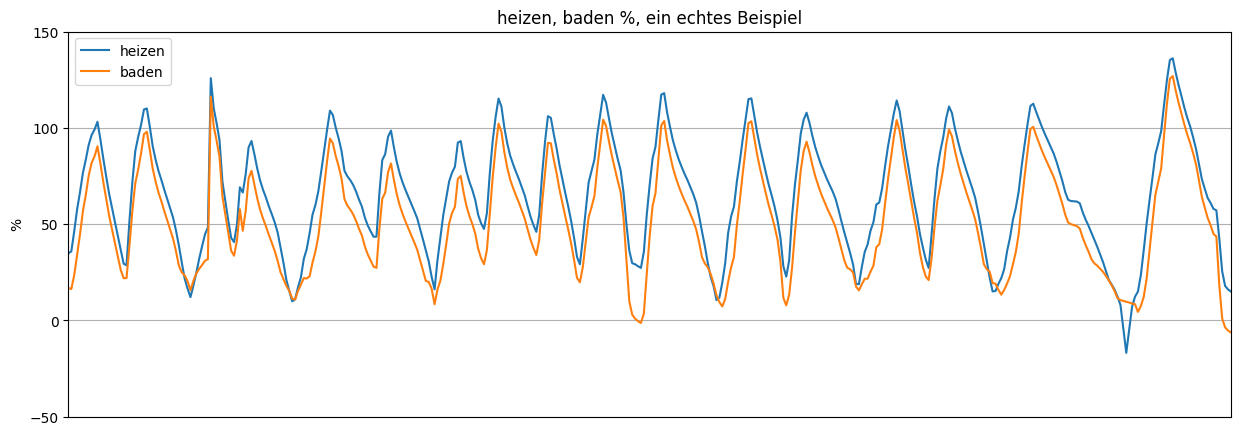

In [11]:
plt.rcParams['figure.figsize'] = [15, 5]
fig2, ax2 = plt.subplots()

ax2.plot(t, heizen_list, label='heizen')
ax2.plot(t, baden_list, label='baden')
ax2.legend()

ax2.set(xlabel='', ylabel='%',
       title='heizen, baden %, ein echtes Beispiel')
ax2.grid(axis='y')
y_grid_levels = [-50, 0, 50, 100, 150]
ax2.set_ylim(min(y_grid_levels), max(y_grid_levels))
ax2.set_yticks(y_grid_levels)

ax2.set_xlim(800, 1200)

ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.show()

In [12]:
import datetime

for liste in data:
    seconds = int(float((liste[0])))/1000
    #timesinceepoch_s = int(liste[0]) #int(list[0]/1000)
    #print(timesinceepoch_s)
    unten_C=float(liste[1])
    mitte_C=float(liste[2])
    oben_C=float(liste[3])
    time=datetime.datetime.fromtimestamp(seconds)
    print(f'{time}, u {unten_C:.2f},  m {mitte_C:.2f}, o {oben_C:.2f}, heizen {fuellgrad_heizen_prozent(unten_C, mitte_C, oben_C):4.0f}, baden {fuellgrad_baden_prozent(unten_C, mitte_C, oben_C):4.0f}, fuellgrad_dezentral_prozent {fuellgrad_dezentral_prozent(unten_C, mitte_C, oben_C):4.0f}')


2024-02-24 14:06:40, u 46.69,  m 56.53, o 56.16, heizen   86, baden   68, fuellgrad_dezentral_prozent   68
2024-02-24 14:06:40, u 48.50,  m 57.75, o 57.40, heizen   94, baden   78, fuellgrad_dezentral_prozent   78
2024-02-24 14:06:40, u 50.04,  m 58.75, o 58.46, heizen  101, baden   87, fuellgrad_dezentral_prozent   87
2024-02-24 16:53:20, u 51.17,  m 58.44, o 58.44, heizen  104, baden   90, fuellgrad_dezentral_prozent   90
2024-02-24 16:53:20, u 53.19,  m 60.23, o 59.77, heizen  114, baden  102, fuellgrad_dezentral_prozent  102
2024-02-24 16:53:20, u 55.25,  m 61.94, o 61.46, heizen  124, baden  115, fuellgrad_dezentral_prozent  115
2024-02-24 16:53:20, u 56.77,  m 63.38, o 62.96, heizen  132, baden  126, fuellgrad_dezentral_prozent  126
2024-02-24 16:53:20, u 55.87,  m 63.42, o 63.57, heizen  130, baden  125, fuellgrad_dezentral_prozent  125
2024-02-24 16:53:20, u 55.25,  m 60.29, o 63.19, heizen  121, baden  115, fuellgrad_dezentral_prozent  115
2024-02-24 19:40:00, u 54.50,  m 57.5